## Michigan Weather Map

This is the main jupyter notebook that takes the data and creates maps in `matplotlib`.

### Setup and Importing Modules

In [ ]:
# Importing modules
import requests 
from my_api_info import get_noaa_token
from time import sleep
import cartopy.crs as ccrs
import numpy as np
import cartopy.feature as cfeature
import cartopy.io.shapereader as shapereader
import pandas as pd
from metpy.cbook import get_test_data
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
from MI_info import stations_MI, FIPS_MI, stationids_to_FIPS

### Creating Relevant Data Structures

In [12]:
# Import the CSV that has county ZIPS and FIPS codes, 
# and then make it so it only has MI counties
counties_df = pd.read_csv('./ZIP-COUNTY-FIPS.csv')

counties_df = counties_df[counties_df['STATE'] == 'MI'].reset_index()

counties_df = counties_df[['ZIP','COUNTYNAME','STCOUNTYFP']]

In [13]:
# Cell to experiment with the counties_df DataFrame
counties_df.head()

,ZIP,COUNTYNAME,STCOUNTYFP
0,48738,Alcona County,26001
1,48762,Alcona County,26001
2,48750,Alcona County,26001
3,48721,Alcona County,26001
4,48728,Alcona County,26001


In [14]:
# Create a function that eats a ZIP and return
# the FIPS code to which that ZIP belongs as integers
def ZIP_to_FIPS(ZIP):
    matches = counties_df.loc[counties_df['ZIP'] == ZIP]
    matching_FIPS = list(matches.STCOUNTYFP.values)
    return matching_FIPS

In [15]:
# Get and read the shapefile of the US counties
get_test_data('us_counties_20m.shp', as_file_obj=False)
get_test_data('us_counties_20m.shx', as_file_obj=False)
get_test_data('us_counties_20m.dbf', as_file_obj=False)

counties = shapereader.Reader(get_test_data('us_counties_20m.shp', as_file_obj=False))

In [17]:
# This function returns all MI stations (in stations_MI) and 
# their monthly rainfall for the input month
def get_PRCP_MI(month):
    headers = {'token':get_noaa_token()}
    base_url = 'https://www.ncei.noaa.gov/cdo-web/api/v2'
    extension = '/data'
    url = base_url + extension

    startdate = month + '-01'
    parameters = {'datasetid':'GSOM',
                  'startdate':startdate,
                  'enddate':startdate,
                  'units':'metric',
                  'datatypeid':'PRCP',
                  'station':'GHCND:US',
                  'locationid':'FIPS:' + '26',
                  'limit':400}
    r = requests.get(url,
                     headers=headers,
                     params=parameters)
    return r

In [18]:
# Here we get the monthly precipitation in MI
rfall_MI_2020_01 = get_PRCP_MI('2020-01')

In [19]:
# Testing
d = {1:[3]}

In [20]:
# We want to take an average across all stations in a given 
# county. To do this we first create a mapping of FIPS to 
# (a1, ..., an) where ai is a given record of a station 
# in that county. Then we'll average them.
FIPS_to_rfalls = {keys:() for keys in FIPS_MI}

for entry in rfall_MI_2020_01.json()['results']:
    # Get rid of GHCND out front of stationid
    stationid = entry['station'][6:]
    FIPS = stationids_to_FIPS[stationid]
    value = entry['value']
    FIPS_to_rfalls[FIPS] = (value,) + FIPS_to_rfalls[FIPS]

In [21]:
# This is a dict mapping FIPS to values of rainfall, 
# averaged across all station observations in the given
# county
FIPS_to_rfall = {}

for FIPS in FIPS_MI:
    FIPS_to_rfall[FIPS] = np.mean(FIPS_to_rfalls[FIPS])

c:\Users\chris\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\chris\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [22]:
# Create function to specify month then output FIPS_to_rfall for
# that month 
def month_to_FIPS_to_rfall(month):
    r = get_PRCP_MI(month)
    FIPS_to_rfalls = {keys:() for keys in FIPS_MI}

    for entry in r.json()['results']:
        # Get rid of GHCND out front of stationid
        stationid = entry['station'][6:]
        FIPS = stationids_to_FIPS[stationid]
        value = entry['value']
        FIPS_to_rfalls[FIPS] = (value,) + FIPS_to_rfalls[FIPS]

        FIPS_to_rfall = {}

    for FIPS in FIPS_MI:
        FIPS_to_rfall[FIPS] = np.mean(FIPS_to_rfalls[FIPS])
    
    return FIPS_to_rfall

### Plotting function definitions for county geometries

### Plotting rainfall data for Jan 2020 in Michigan

In [23]:
# Here is a dictionary mapping county geometries to rainfall
geom_rfall = {rec.geometry:FIPS_to_rfall.get(int(rec.attributes['GEOID']),0)
                   for rec in counties.records()}

In [24]:
# Here is our shader function definition, a function
# that we can call to color counties by rainfall

max_rfall = max(FIPS_to_rfall.values())

def color_rain(geom):
    rfall = geom_rfall.get(geom)
    if rfall > 0: 
        cmap = plt.get_cmap('Blues')
        norm = plt.Normalize(0,max_rfall)
        facecolor = cmap(norm(rfall))
    elif np.isnan(rfall): # if no rainfall data from county
        facecolor = 'peachpuff'
    else:
        facecolor = 'none'
    return {'edgecolor':'black', 'facecolor':facecolor}

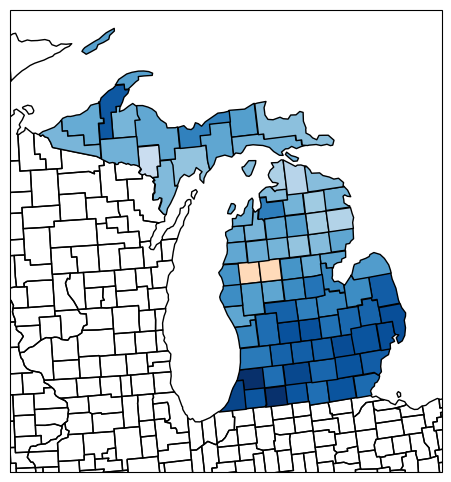

In [25]:
# Plotting the map 
fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(projection=ccrs.LambertConformal())

ax.add_feature(cfeature.COASTLINE)
# ax.add_feature(cfeature.STATES)
ax.set_extent((-91, -82, 41, 48))

# Plot the counties with rainfall data
ax.add_geometries(counties.geometries(),
                  ccrs.PlateCarree(),
                  styler=color_rain)

plt.show()

##### Notes

A success!! We are missing two counties for years around 2020: Lake and Osceola. Let's see if they just didn't record rainfall data for that month by trying a different month.

### Plotting Rainfall Data for variouths months (one at a time) in Michigan

In [ ]:
# Setting up the data structures
test_month = '1997-11'

FIPS_to_rfall_1 = month_to_FIPS_to_rfall(test_month)
geom_rfall = {rec.geometry:FIPS_to_rfall_1.get(int(rec.attributes['GEOID']),0)
                   for rec in counties.records()}

max_rfall = max(FIPS_to_rfall_1.values())

def color_rain(geom):
    rfall = geom_rfall.get(geom)
    if rfall > 0: 
        cmap = plt.get_cmap('Blues')
        norm = plt.Normalize(0,max_rfall)
        facecolor = cmap(norm(rfall))
    elif np.isnan(rfall):
        facecolor = 'peachpuff'
    else:
        facecolor = 'none'
    return {'edgecolor':'black', 'facecolor':facecolor}

# Plotting
# Plotting the map 
fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(projection=ccrs.LambertConformal())

ax.add_feature(cfeature.COASTLINE)
# ax.add_feature(cfeature.STATES)
ax.set_extent((-91, -82, 41, 48))

# Plot the counties with rainfall data
ax.add_geometries(counties.geometries(),
                  ccrs.PlateCarree(),
                  styler=color_rain)

# Niceties
ax.set_title('Average Rainfall in MI Counties in month of ' + test_month)

plt.show()

### A function to plot

In [ ]:
# Here we create a function to plot a given month's rainfall data
def map_rfall_month(month):
    # Setting up the data structures
    FIPS_to_rfall = month_to_FIPS_to_rfall(month)
    geom_rfall = {rec.geometry:FIPS_to_rfall.get(int(rec.attributes['GEOID']),0)
                       for rec in counties.records()}

    max_rfall = max(FIPS_to_rfall.values())

    def color_rain(geom):
        rfall = geom_rfall.get(geom)
        if rfall > 0: 
            cmap = plt.get_cmap('Blues')
            norm = plt.Normalize(0,max_rfall)
            facecolor = cmap(norm(rfall))
        elif np.isnan(rfall):
            facecolor = 'peachpuff'
        else:
            facecolor = 'none'
        return {'edgecolor':'black', 'facecolor':facecolor}

    # Plotting
    # Plotting the map 
    fig = plt.figure(figsize=(8,6))

    ax = fig.add_subplot(projection=ccrs.LambertConformal())

    ax.add_feature(cfeature.COASTLINE)
    # ax.add_feature(cfeature.STATES) this double-outlines and looks bad
    ax.set_extent((-91, -82, 41, 48))

    # Plot the counties with rainfall data
    ax.add_geometries(counties.geometries(),
                      ccrs.PlateCarree(),
                      styler=color_rain)
    
    # Niceties 
    ax.set_title("Average Rainfall in MI Counties in month of " + month)

    plt.show()

### Testing our plotting function

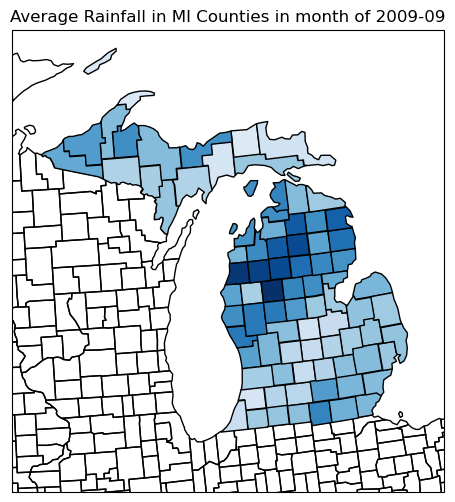

In [ ]:
map_rfall_month('2009-09')

### Multiple plots

2020-01


C:\Users\chris\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\chris\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[92.52000000000001, 91.21428571428571, 90.2875, 97.82666666666667]
2020-02
[26.083333333333332, 28.428571428571427, 26.457142857142856, 27.915384615384614]
2020-03
[54.65, 87.0142857142857, 90.95882352941176, 83.64285714285715]
2020-04
[37.885714285714286, 62.542857142857144, 95.675, 52.1857142857143]
2020-05
[112.84285714285714, 107.24285714285715, 132.91538461538462, 97.56153846153845]
2020-06
[55.285714285714285, 68.67142857142858, 75.45925925925927, 82.33333333333334]
2020-07
[92.55714285714286, 75.9, 91.53846153846153, 87.71538461538461]
2020-08
[100.625, 55.55714285714286, 66.6375, 156.02666666666667]
2020-09
[79.7125, 45.96666666666666, 68.43199999999999, 72.11999999999999]
2020-10
[68.85714285714286, 70.0, 85.22083333333335, 61.23571428571428]
2020-11
[46.824999999999996, 59.74000000000001, 64.39047619047619, 57.9153846153846]
2020-12
[45.3125, 32.64, 69.98947368421054, 39.75]
[118.38000000000002, 56.8, 119.25, 132.9333333333333, 225.75, 115.2, 211.625, 177.25, 153.1, 228.0, 92

{0, nan, 40.3, 41.7, 44.75, 45.96666666666666, 45.8, 49.9, 50.45, 51.9, 52.583333333333336, 53.7, 52.9, 50.544444444444444, 54.05, 55.2, 56.08, 56.66666666666667, 54.2, 59.93333333333334, 59.7, 61.57826086956521, 62.4, 63.974999999999994, 64.7, 59.300000000000004, 59.0, 68.43199999999999, 68.88, 68.33333333333333, 71.9, 72.0, 72.11999999999999, 74.32857142857144, 75.4, 77.33, 75.03333333333335, 79.7, 80.725, 81.8, 78.525, 83.4, 79.94999999999999, 85.975, 79.25, 79.7125, 80.74000000000001, 84.0, 86.625, 87.75, 88.28333333333335, 86.0, 86.72857142857143, 91.3, 96.05, 97.89999999999999, 98.3, 97.4, 99.38, 97.0, 100.16666666666666, 96.5, 107.76666666666665, 108.80000000000001, 109.86000000000001, 110.78571428571429, 118.77142857142859, 153.1, 59.67999999999999, 68.3, 69.96666666666665, 70.69999999999999, 70.56500000000001, 71.3, 72.36666666666667, 76.75, 78.825, 78.9, nan, 85.81666666666666, 85.125, 87.39999999999999}
{0, 44.55, 55.288888888888884, 56.8695652173913, 58.949999999999996, 59.

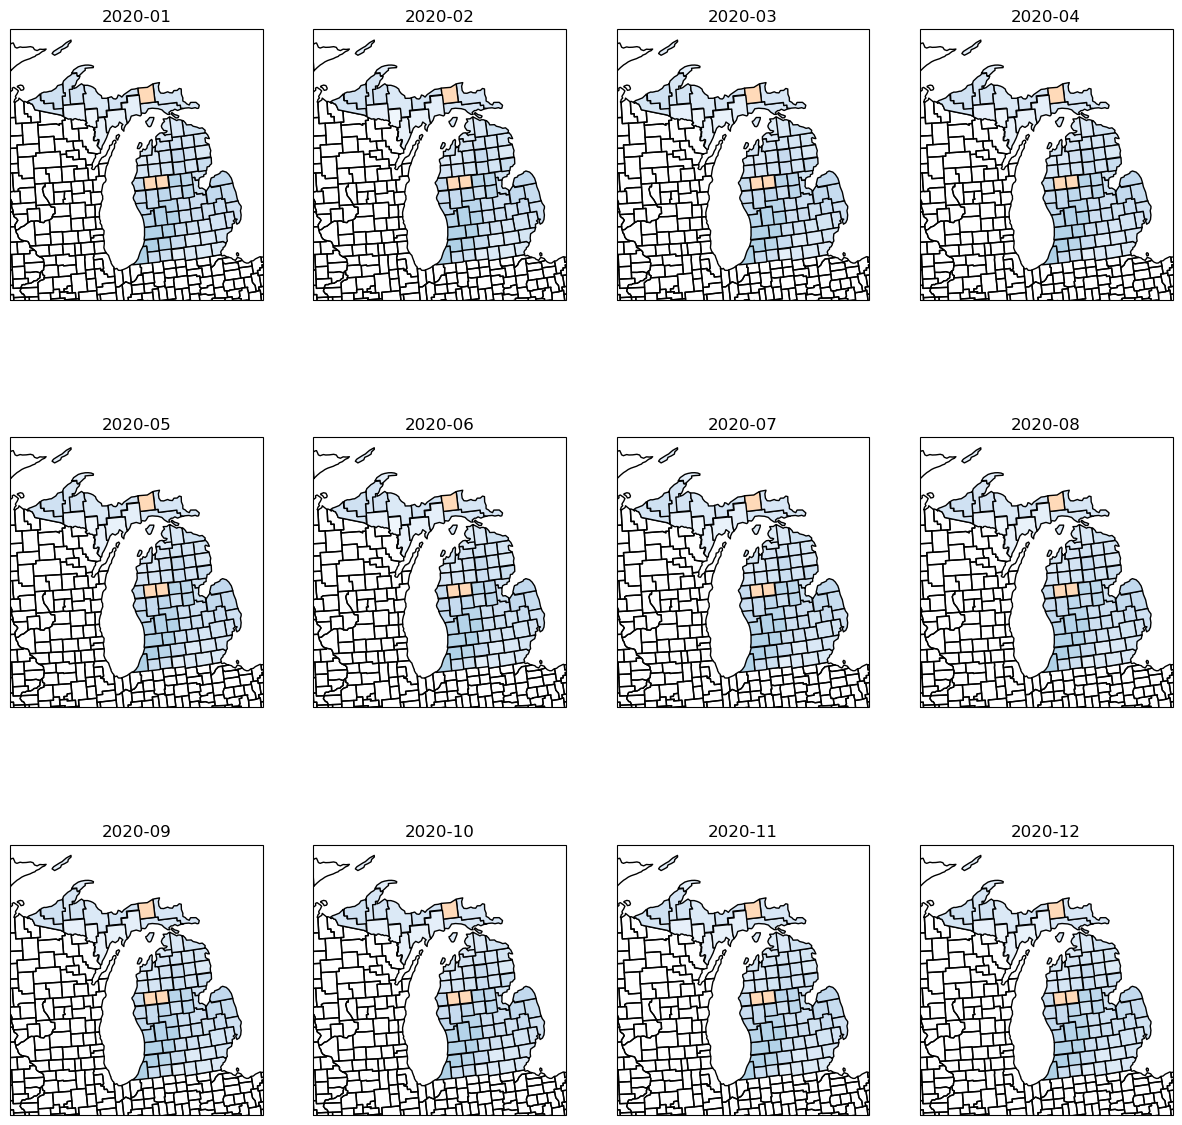

In [ ]:
# Let's make a function displaying a plot of the whole year's 
# rainfall by month

year = '2020'
cmap_used = 'Blues'

# Create month strings
months = []
for i in range(1, 13):
    if i < 10:
        MM = '0' + str(i)
    else:
        MM = str(i)
    months.append(year + '-' + MM)

# Keep track of max rfall across all months that year
max_rfall_each_month = []
geom_rfall_each_month = []
FIPS_to_rfall_each_month = []

for month in months:
    sleep(3)
    print(month)
    FIPS_to_rfall = month_to_FIPS_to_rfall(month)
    FIPS_to_rfall_each_month.append(FIPS_to_rfall)
    geom_rfall_each_month.append({rec.geometry:FIPS_to_rfall.get(int(rec.attributes['GEOID']), 0)
                                  for rec in counties.records()})

    max_rfall_each_month.append(max(FIPS_to_rfall.values()))
    print(list(FIPS_to_rfall.values())[0:4])
    
# Testing
print(max_rfall_each_month)

# Max rainfall for whole year
max_rfall = max(max_rfall_each_month)

# Make the subplots and figure
fig, ax = plt.subplots(3,4, 
                       figsize=(15,15),
                       subplot_kw={'projection':ccrs.LambertConformal()})

# Now we loop again and plot 
for i in range(0,12):
    geom_rfall = geom_rfall_each_month[i]
    FIPS_to_rfall = FIPS_to_rfall_each_month[i]
    
    def color_rain(geom):
        rfall = geom_rfall.get(geom)
        if rfall > 0:
            cmap = plt.get_cmap(cmap_used)
            norm = plt.Normalize(0, max_rfall)
            facecolor = cmap(norm(rfall))
        elif np.isnan(rfall):
            facecolor = 'peachpuff'
        else:
            facecolor = 'none'
        return {'edgecolor':'black', 'facecolor':facecolor}

    ax[i // 4, i % 4].add_feature(cfeature.COASTLINE)
    ax[i // 4, i % 4].set_extent((-91, -82, 41, 48))
    ax[i // 4, i % 4].add_geometries(counties.geometries(),
                                     ccrs.PlateCarree(),
                                     styler=color_rain)
    ax[i // 4, i % 4].set_title(months[i])
    
plt.show()


                
                

In [ ]:
set(geom_rfall.values())

{0,
 9.700000000000001,
 16.45,
 17.2,
 18.75,
 21.1,
 21.7,
 22.3,
 27.416666666666668,
 28.766666666666666,
 29.299999999999997,
 29.82857142857143,
 30.6,
 30.8,
 32.375,
 32.5125,
 32.64,
 32.65833333333334,
 33.0,
 33.39,
 36.712500000000006,
 37.199999999999996,
 37.4,
 37.650000000000006,
 38.41428571428572,
 39.4,
 39.525,
 39.6,
 39.75,
 40.2,
 40.53333333333334,
 41.2,
 41.43333333333333,
 41.56666666666666,
 41.9,
 41.98333333333334,
 42.15,
 42.7125,
 43.0,
 43.43333333333334,
 43.45,
 44.95,
 45.0,
 45.3125,
 45.64,
 45.925,
 46.43333333333334,
 48.150000000000006,
 48.650000000000006,
 49.58,
 49.81666666666666,
 50.1,
 50.4,
 50.5,
 51.5,
 52.43333333333334,
 53.4,
 53.625,
 54.4,
 54.699999999999996,
 55.800000000000004,
 55.9,
 56.15,
 57.5,
 58.825,
 59.724999999999994,
 59.9,
 62.199999999999996,
 62.650000000000006,
 64.4,
 65.30000000000001,
 65.7375,
 66.225,
 67.5,
 69.98947368421054,
 70.7,
 71.1,
 71.21428571428571,
 72.61250000000001,
 73.875,
 nan,
 nan,
 nan

#### Notes

Suppose we have already called to the API and have a `dict` returned which has the stationids and the relevant data in it. We need to then have some function FIPS_to_rfall which eats a FIPS code and outputs the rainfall for that month. We thus need to identify which stations have that FIPS code associated to them. That is, we need a map of FIPS to stationids. 

Once we have this mapping, we need to call all data for a given month, and then create a mapping of FIPS codes to rainfall for the given month.

### Testing

In [ ]:
# The missing counties are Lake and Osceola with FIPS codes:
# These are in our FIPS_MI dict and our counties_df DataFrame
# Do they just never record monthly rainfall?
r = get_PRCP_MI('2020-01')

In [ ]:
data = pd.DataFrame(r.json()['results'])
data.head()

,date,datatype,station,attributes,value
0,2020-01-01T00:00:00,PRCP,GHCND:US1MIAG0006,",,,N",74.5
1,2020-01-01T00:00:00,PRCP,GHCND:US1MIAN0004,"5,a,,N",70.6
2,2020-01-01T00:00:00,PRCP,GHCND:US1MIAN0019,",,,N",83.4
3,2020-01-01T00:00:00,PRCP,GHCND:US1MIAN0020,"1,,,N",82.2
4,2020-01-01T00:00:00,PRCP,GHCND:US1MIAN0025,",,,N",108.3


In [ ]:
for d in stationids_to_FIPS:
    if stationids_to_FIPS[d] == 26085:
        print(d)

USC00200446
USC00204969
USC00205165
USR0000MBAL


In [ ]:
# Manually checking, it's just that the get_PRCP_MI for the month
# did not return any data. What if we call these stations directly?
month = '2008-01'

headers = {'token':get_noaa_token()}
base_url = 'https://www.ncei.noaa.gov/cdo-web/api/v2'
extension = '/data'
url = base_url + extension
startdate = month + '-01'
parameters = {'datasetid':'GSOM',
              'startdate':startdate,
              'enddate':'2010-01-01',
              'units':'metric',
              'datatypeid':'PRCP',
              'stationid':'GHCND:USC00200446',
              'limit':400}
r = requests.get(url,
                 headers=headers,
                 params=parameters)


In [ ]:
r.json()

{'metadata': {'resultset': {'offset': 1, 'count': 15, 'limit': 400}},
 'results': [{'date': '2008-02-01T00:00:00',
   'datatype': 'PRCP',
   'station': 'GHCND:USC00200446',
   'attributes': '1,a,,0',
   'value': 65.4},
  {'date': '2008-04-01T00:00:00',
   'datatype': 'PRCP',
   'station': 'GHCND:USC00200446',
   'attributes': '3,,,0',
   'value': 43.6},
  {'date': '2008-05-01T00:00:00',
   'datatype': 'PRCP',
   'station': 'GHCND:USC00200446',
   'attributes': ',a,,0',
   'value': 28.7},
  {'date': '2008-08-01T00:00:00',
   'datatype': 'PRCP',
   'station': 'GHCND:USC00200446',
   'attributes': '3,a,,0',
   'value': 14.2},
  {'date': '2008-11-01T00:00:00',
   'datatype': 'PRCP',
   'station': 'GHCND:USC00200446',
   'attributes': '3,a,,0',
   'value': 30.0},
  {'date': '2009-01-01T00:00:00',
   'datatype': 'PRCP',
   'station': 'GHCND:USC00200446',
   'attributes': ',a,,0',
   'value': 26.0},
  {'date': '2009-02-01T00:00:00',
   'datatype': 'PRCP',
   'station': 'GHCND:USC00200446',
  

In [ ]:
stationids_to_FIPS['US1MIAG0001']

In [ ]:
# Testing that the stationids_to_FIPS dict is correct
geolocator = Nominatim(user_agent='https')
test_stations = list(stationids_to_FIPS.keys())[1000:]
for station in test_stations:
    loc_county = geolocator.reverse(stations_MI[station]).raw['address']['county']
    loc_fips = set(counties_df[counties_df['COUNTYNAME'] == loc_county].STCOUNTYFP.values)
    dict_FIPS = stationids_to_FIPS[station]
    print("stationids_to_FIPS:", dict_FIPS)
    print("gelocator look-up:", loc_fips)
    
# Testing random indices indicates our stations_to_FIPS dict is good!

In [ ]:
MI_FIPS_list = []

for rec in counties.records():
    if rec.attributes['GEOID'][:2] == '26':
        MI_FIPS_list.append(rec.attributes['GEOID'])

In [ ]:
base_url = 'https://www.ncei.noaa.gov/cdo-web/api/v2'
extension = '/data'
url = base_url + extension

In [ ]:
headers = {'token':get_noaa_token()}

In [ ]:
# Let's write a function that returns all station data 
# (PRCP) in Michigan for input month
# MI is FIPS:26
# Month input in YYYY-MM format
def get_PRCP_MI(month):
    headers = {'token':get_noaa_token()}
    base_url = 'https://www.ncei.noaa.gov/cdo-web/api/v2'
    extension = '/data'
    url = base_url + extension

    startdate = month + '-01'
    parameters = {'datasetid':'GSOM',
                  'startdate':startdate,
                  'enddate':startdate,
                  'units':'metric',
                  'datatypeid':'PRCP',
                  'station':'GHCND:US',
                  'locationid':'FIPS:' + '26',
                  'limit':400}
    r = requests.get(url,
                     headers=headers,
                     params=parameters)
    return r

In [ ]:
def get_monthly_prcp_MI(month):
    startdate = month + '-01'
    enddate = month + '-01'
    parameters = {'datasetid':'GSOM',
                  'startdate':startdate,
                  'enddate':enddate,
                  'units':'metric',
                  'datatypeid':'PRCP',
                  'station':'GHCN:US',
                  'locationid':MI_FIPS_str,
                  'limit':400}
    r = requests.get(url,
                     headers=headers,
                     params=parameters)
    return r

In [ ]:
r = get_monthly_prcp_MI('2020-01')

In [ ]:
r.json()['results']

In [ ]:
stationid_to_FIPS = {s:f for f, s in FIPS_to_stationid.items()}

In [ ]:
def get_FIPS_rfall_monthly(month):
    r = get_monthly_prcp_MI(month)
    FIPS_to_rfall = {}
    for FIPS in MI_FIPS_list:
        rfalls = []
        for result in r.json()['results']:
            if result['station'] in stationid_to_FIPS.keys():
                if stationid_to_FIPS[result['station']] == FIPS:
                    rfalls.append(result['value'])
        if rfalls == []:
            FIPS_to_rfall[FIPS] = 0
        else:
            FIPS_to_rfall[FIPS] = np.mean(rfalls)
    return FIPS_to_rfall

In [ ]:
next(counties.records()).attributes['GEOID']

In [ ]:
rfall = get_FIPS_rfall_monthly('2020-01')

In [ ]:
rfall

In [ ]:
county_rfall = {rec.geometry:rfall.get(rec.attributes['GEOID'],0)
                   for rec in counties.records()}

In [ ]:
def color_rain(geom):
    rfall = county_rfall.get(geom)
    if rfall > 0: 
        cmap = plt.get_cmap('Blues')
        norm = plt.Normalize(0,max(county_rfall.values()))
        facecolor = cmap(norm(rfall))
    else:
        facecolor = 'none'
    return {'edgecolor':'black', 'facecolor':facecolor}

In [ ]:
fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(projection=ccrs.LambertConformal())

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
ax.add_geometries(counties.geometries(),
                  ccrs.PlateCarree(),
                  styler=color_rain)
ax.set_extent((-91, -82, 41, 48))

plt.show()